**Лабораторная работа №7**
Решить краевую задачу для дифференциального уравнения эллиптического типа. Аппроксимацию уравнения произвести с использованием центрально-разностной схемы. Для решения дискретного аналога применить следующие методы: метод простых итераций (метод Либмана), метод Зейделя, метод простых итераций с верхней релаксацией. Вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением $U(x,y)$. Исследовать зависимость погрешности от сеточных параметров $h_x, h_y$

$\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2} = -2\frac{\partial u}{\partial x}-3u$,

$u(0,y) = \cos{y}$,

$u(\frac{\pi}{2}, y) = 0$,

$u(x,0) = e^{-x}\cos{x}$,

$u(x, \frac{\pi}{2}) = 0$.

Аналитическое решение: $U(x,y)=e^{-x}\cos{x}\cos{y}$

liebmann_method: k = 222
zeildel_method: k = 122
sor_method: k = 40


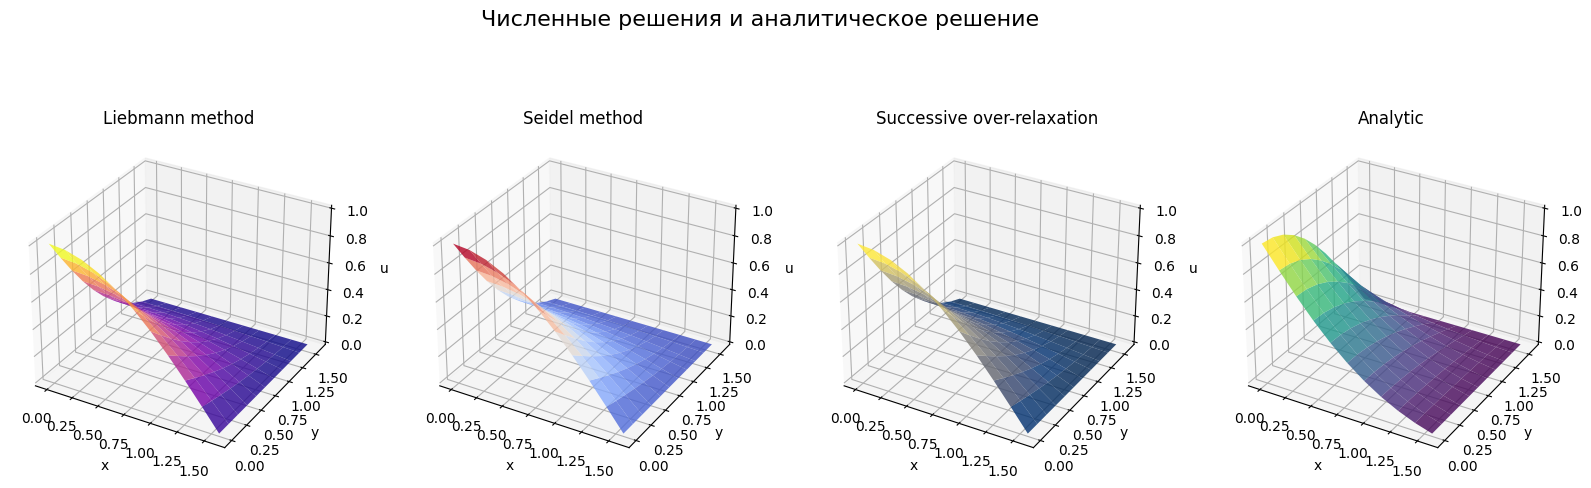

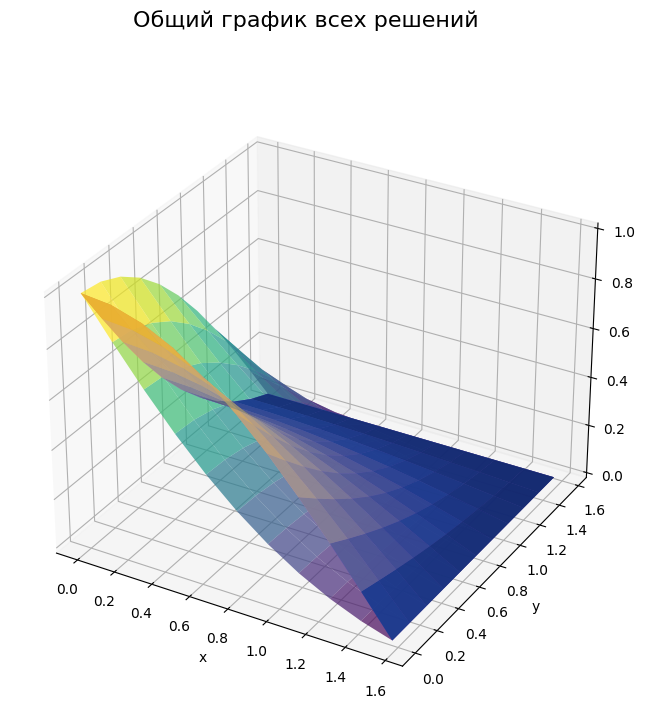

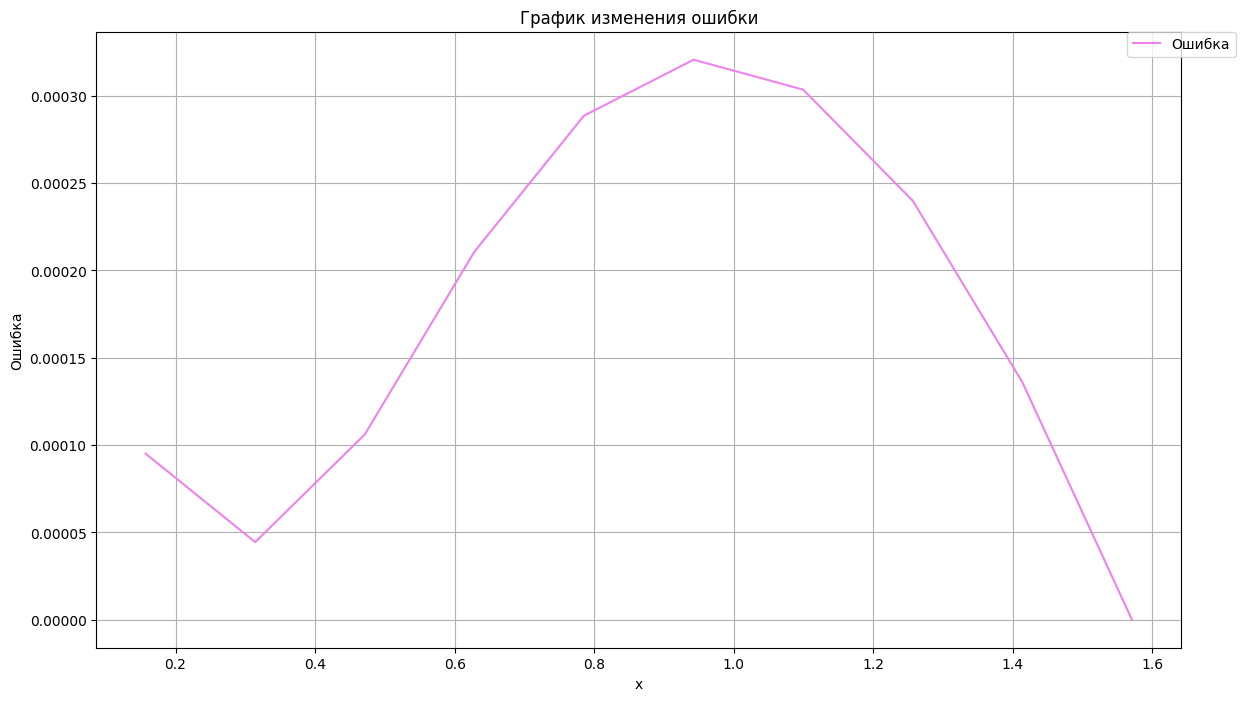

In [4]:
import copy
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def analytic_solution(x, y):
    """Аналитическое решение задачи."""
    return np.exp(-x) * np.cos(x) * np.cos(y)

def phi1(y):
    """Граничное условие на границе x=0."""
    return np.cos(y)

def phi2(y):
    """Граничное условие на границе x=lx."""
    return 0

def phi3(x):
    """Граничное условие на границе y=0."""
    return np.exp(-x) * np.cos(x)

def phi4(x):
    """Граничное условие на границе y=ly."""
    return 0


def show_result(y_axis, x_axis, u1, u2, u3):
    """Отображение результатов численных методов и аналитического решения."""
    fig, axes = plt.subplots(1, 4, figsize=(20, 6), subplot_kw={"projection": "3d"})
    fig.suptitle("Численные решения и аналитическое решение", fontsize=16)

    # Создание сетки координат для построения графиков
    xgrid, ygrid = np.meshgrid(x_axis, y_axis)

    # Подготовка данных для каждого метода
    solutions = [
        (u1, "Liebmann method", "plasma"),
        (u2, "Seidel method", "coolwarm"),
        (u3, "Successive over-relaxation", "cividis"),
        (analytic_solution(xgrid, ygrid), "Analytic", "viridis"),
    ]

    # Построение поверхностей для каждого метода
    for ax, (solution, title, cmap) in zip(axes, solutions):
        surf = ax.plot_surface(
            xgrid, ygrid, solution, cmap=cmap, alpha=0.8
        )
        ax.set_title(title, fontsize=12)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("u")

    # Создание общего графика, отображающего все решения вместе
    fig_all = plt.figure(figsize=(10, 8))
    ax_all = fig_all.add_subplot(111, projection="3d")
    fig_all.suptitle("Общий график всех решений", fontsize=16)

    # Построение поверхностей для всех методов на одном графике
    ax_all.plot_surface(xgrid, ygrid, u1, cmap="plasma", alpha=0.6, label="Liebmann")
    ax_all.plot_surface(xgrid, ygrid, u2, cmap="coolwarm", alpha=0.6, label="Seidel")
    ax_all.plot_surface(
        xgrid, ygrid, u3, cmap="cividis", alpha=0.6, label="Successive over-relaxation"
    )
    ax_all.plot_surface(xgrid, ygrid, analytic_solution(xgrid, ygrid), cmap="viridis", alpha=0.7, label="Analytic")
    ax_all.set_xlabel("x")
    ax_all.set_ylabel("y")
    ax_all.set_zlabel("u")

    # Отображение всех графиков
    plt.show()

def show_inaccuracy(y_axis, x_axis, u):
    """Отображение графика изменения ошибки по x."""
    inaccuracy = np.zeros(count_x + 1)
    for i in range(count_x + 1):
        # Вычисление максимальной абсолютной ошибки для каждого x
        inaccuracy[i] = np.max(
            np.abs(u[i] - np.array([analytic_solution(x_axis[i], y) for y in y_axis]))
        )

    plt.figure(figsize=(14, 8))
    plt.plot(x_axis[1:], inaccuracy[1:], "violet", label="Ошибка")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper right", borderaxespad=0.0)
    plt.title("График изменения ошибки")
    plt.xlabel("x")
    plt.ylabel("Ошибка")
    plt.grid(True)
    plt.show()


# Основные параметры задачи
count_x = 10        # Количество узлов по оси x
count_y = 10        # Количество узлов по оси y
lx = np.pi / 2      # Длина области по оси x
ly = np.pi / 2      # Длина области по оси y
hx = lx / count_x   # Шаг по оси x
hy = ly / count_y   # Шаг по оси y
bx = 2              # Коэффициент при первом производном по x
by = 0              # Коэффициент при первом производном по y
c = 3               # Коэффициент при u
eps = 0.00001         # Точность остановки итераций
max_iterations = 1000  # Максимальное количество итераций


def liebmann_method():
    """Реализация метода Лейбмана для решения задачи."""
    u = np.zeros((count_x + 1, count_y + 1))  # Инициализация сетки решения нулями

    # Установка граничных условий
    u[0, 0] = phi1(0)                # Условие в точке (0,0)
    u[-1, -1] = phi2(-hy)            # Условие в точке (lx, ly)

    for i in range(1, count_x):
        u[i, 0] = phi3(i * hx)        # Граничные условия на y=0
        u[i, -1] = phi4(i * hx)       # Граничные условия на y=ly

    for j in range(1, count_y):
        u[0, j] = phi1(j * hy)        # Граничные условия на x=0
        u[-1, j] = phi2(j * hy)       # Граничные условия на x=lx
        for i in range(1, count_x):
            # Инициализация внутренних узлов линейной интерполяцией
            u[i, j] = u[0, j] + (u[-1, j] - u[0, j]) / lx * i * hx

    k = 0  # Счетчик итераций
    while True:
        k += 1
        if k > max_iterations:
            print("Достигнуто максимальное число итераций!")
            break

        u_prev = copy.deepcopy(u)  # Сохранение предыдущего состояния решения

        # Итерация по внутренним узлам сетки
        for j in range(1, count_y):
            for i in range(1, count_x):
                u[i, j] = (
                    -(u_prev[i + 1, j] + u_prev[i - 1, j])
                    - hx**2 * (u_prev[i, j + 1] + u_prev[i, j - 1]) / (hy**2)
                    - bx * hx * (u_prev[i + 1, j] - u_prev[i - 1, j]) / 2
                    - by * hx**2 * (u_prev[i, j + 1] - u_prev[i, j - 1]) / (2 * hy)
                ) / (c * hx**2 - 2 * (hy * hy + 1 * hx**2) / (hy**2))

        # Вычисление нормы разности для проверки сходимости
        norm = np.linalg.norm(u - u_prev, np.inf)
        if norm <= eps:
            break

    print("liebmann_method: k =", k)  # Вывод количества итераций
    return u


def sor_method(omega):
    """Реализация метода Зейделя с последующей релаксацией (SOR) для решения задачи."""
    u = np.zeros((count_x + 1, count_y + 1))  # Инициализация сетки решения нулями

    # Установка граничных условий
    u[0, 0] = phi1(0)                # Условие в точке (0,0)
    u[-1, -1] = phi2(hy)             # Условие в точке (lx, ly)

    for i in range(1, count_x):
        u[i, 0] = phi3(i * hx)        # Граничные условия на y=0
        u[i, -1] = phi4(i * hx)       # Граничные условия на y=ly

    for j in range(1, count_y):
        u[0, j] = phi1(j * hy)        # Граничные условия на x=0
        u[-1, j] = phi2(j * hy)       # Граничные условия на x=lx
        for i in range(1, count_x):
            # Инициализация внутренних узлов линейной интерполяцией
            u[i, j] = u[0, j] + (u[-1, j] - u[0, j]) / lx * i * hx

    k = 0  # Счетчик итераций
    while True:
        k = k + 1
        if k > max_iterations:
            print("Достигнуто максимальное число итераций!")
            break

        u_prev = copy.deepcopy(u)  # Сохранение предыдущего состояния решения

        # Итерация по внутренним узлам сетки
        for j in range(1, count_y):
            for i in range(1, count_x):
                u[i, j] = (
                    (
                        -(u_prev[i + 1, j] + u[i - 1, j])
                        - 1 * hx**2 * (u_prev[i, j + 1] + u[i, j - 1]) / (hy**2)
                        - bx * hx * (u_prev[i + 1, j] - u[i - 1, j]) / 2
                        - by * hx**2 * (u_prev[i, j + 1] - u[i, j - 1]) / (2 * hy)
                    )
                    / (c * hx**2 - 2 * (hy**2 + 1 * hx**2) / (hy**2))
                ) * omega + (1 - omega) * u_prev[i, j]  # Применение релаксации

        # Вычисление нормы разности для проверки сходимости
        norm = np.linalg.norm(u - u_prev, np.inf)
        if norm <= eps:
            break

    # Вывод количества итераций и типа метода
    if omega == 1:
        print("zeildel_method: k =", k)
    else:
        print("sor_method: k =", k)

    return u

def get_axis_np(count, mul):
    """Генерация массива координат с заданным шагом."""
    axis = np.zeros(count)
    for i in range(count):
        axis[i] = mul * i
    return axis


# Выполнение методов решения
u1 = liebmann_method()             # Решение методом Лейбмана
u2 = sor_method(1)                 # Решение методом Зейделя (SOR с ω=1)
u3 = sor_method(1.5)               # Решение методом SOR с ω=1.5

# Генерация осей координат
y_axis = get_axis_np(count_y + 1, hy)  # Ось y
x_axis = get_axis_np(count_x + 1, hx)  # Ось x

# Отображение результатов численных методов и аналитического решения
show_result(y_axis, x_axis, u1, u2, u3)

# Отображение графика изменения ошибки для метода Лейбмана
show_inaccuracy(y_axis, x_axis, u1)
